CODE OVERVIEW:
- Molecules are provided in the DUD folder 
- 10 probe molecules are selected from list of molecules for each target 
- Smile strings are converted to Morgan fingerprint 
- similarity calculated with respect to partial charges using Tanimoto calculation
- ROC scores are calculated to test the performeance of the ML model 

INSTRUCTIONS BEFORE RUNNING CODE: 
- Unzip all files in the DUD folder 

In [1]:
from rdkit import Chem 
from rdkit import DataStructs
from rdkit.Chem import AllChem
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.stats as ss 
from scipy.stats import spearmanr 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import os 

In [2]:
# DEFINING FILE NAMES AFTER TARGETS 
targets=['ace','ache','cdk2','cox2','dhfr','egfr','er_agonist','fgfr1','fxa','gpb','gr','hivrt','inha','na','p38','parp','pdgfrb','sahh','src','vegfr2'] 

for t in targets:

    # Opening FILES IN DUD 
    refSmiles_ac = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_' + str(t)+'_actives.dat', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES']) 
    refSmiles_dc = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_' + str(t)+'_decoys.dat', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES'])

    # IDENTIFYING ACITVE AND DECOY
    refSmiles_ac['Active_NotActive'] = 1
    refSmiles_dc['Active_NotActive'] = 0
    
    # Combining the acitve and decoy files together 
    newlist = pd.concat([refSmiles_ac,refSmiles_dc], ignore_index=True)
    
    # APPLYING MORGAN ALGORITHM 
    refMols = []
    for x in newlist['SMILES']:
        m1 = Chem.MolFromSmiles (x)
        refMols.append(AllChem.GetMorganFingerprint(m1,2))
    
    # PROBE MOLECULE 
    # Take the first 10 molecules as probe molecules 
    prbMol = refMols[:10]

    # CREATING DIRECTORY
    dir = '/Users/yada/Documents/UCL/Dissertation/Morgan notebooks/Results/'+str(t)
    if not os.path.exists(dir):
        os.mkdir(dir)    

    roclist = []
    count = 1 
    
    # TANIMOTO SIMILARITY
    for i in prbMol:
        simEsp = [DataStructs.TanimotoSimilarity(i,j) for j in refMols]
        
        data = {'Mol_Title':newlist['# Mol_Title'],'ID':newlist['ID'],'Smiles':newlist['SMILES'],'Active_NotActive':newlist['Active_NotActive'],'Morgan':simEsp}
        newfile = pd.DataFrame(data)
        newfile.to_csv(str(dir)+'/SimilarityMorgan' + str(count)+'.csv')
        count = count + 1
        
        # ROC SCORE
        auc = roc_auc_score(newfile['Active_NotActive'],newfile['Morgan']) 
        roclist.append(auc)

    data = {'ROC Morgan':roclist}
    newfileroc = pd.DataFrame(data)
    newfileroc.to_csv(str(dir) + '/ROCscores.csv')\


In [ ]:
esplist = []
final_file = pd.DataFrame()

for t in targets: 
    files = pd.read_csv ('/Users/yada/Documents/UCL/Dissertation/Morgan notebooks/Results/'+str(t)+'/ROCscores.csv')
    final_file = pd.concat([final_file, files])
   
espavr = np.mean(final_file['ROC Morgan'].to_list())
stdesp = np.std(final_file['ROC Morgan'].to_list())

data = {'Avr ROC':[espavr],'Std Esp':[stdesp],}
newfile = pd.DataFrame(data)
newfile.to_csv('/Users/yada/Documents/UCL/Dissertation/Morgan notebooks/Results/AvrStdResults.csv')

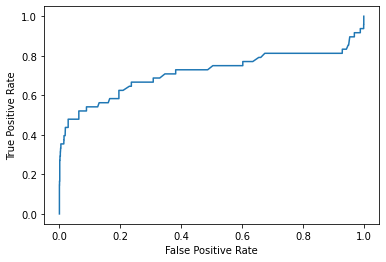

In [4]:
# ROC curve of the most recent probe molecule calculation 

fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],simEsp)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  